# Assignment 3: Classification with Logistic Regression

## Instructions

* Complete the assignment as outlined below.
* Restart your kernel and rerun your cells before submission.
* Submit your completed notebook (.ipynb).

## Dataset Information

The dataset contains health-related data for predicting diabetes. Below are the features:

* `Pregnancies`: Number of pregnancies
* `Glucose`: Plasma glucose concentration
* `BloodPressure`: Diastolic blood pressure (mm Hg)
* `SkinThickness`: Triceps skin fold thickness (mm)
* `Insulin`: 2-hour serum insulin (mu U/ml)
* `BMI`: Body mass index
* `DiabetesPedigreeFunction`: Diabetes pedigree function
* `Age`: Age (years)
* `Outcome`: Target variable (1 = Diabetes, 0 = No Diabetes)

Your goal in this homework is to train a first model for predicting the probability that a patient has diabetes given their healthcare data.

In [13]:
# Suggested packages, you can add more if you think they are necessary.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Download the data. Uncomment if using Colab.
# !gdown https://drive.google.com/uc?id=1-_YcEl0q5LsDXRq5eix9K4gjSq78Ffd5

## Question 1:

1. Load the dataset `diabetes.csv` and display the first 5 rows.
2. Print out all columns in the dataset and identify any missing values.
3. Show the descriptive statistics of the data.

In [3]:
# Load the dataset
diabetes = pd.read_csv("diabetes.csv")
diabetes.head(5)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# Report number of null values
print(f"null values total {diabetes.isnull().sum()}, NA values total {diabetes.isna().sum()}")
print(f"Glucose: {(diabetes['Glucose'] == 0).sum()}") # abnormal, separate from 0 in BMI and blood pressure
print(f"BloodPressure: {(diabetes['BloodPressure'] == 0).sum()}") # abnormal, can combine with BMI
print(f"SkinThickness: {(diabetes['SkinThickness'] == 0).sum()}") # likely part of the data, count = 227
print(f"Insulin: {(diabetes['Insulin'] == 0).sum()}") # likely part of the data, count = 374
print(f"BMI: {(diabetes['BMI'] == 0).sum()}") # abnormal, can combine with BloodPressure

diabetes.drop(diabetes[ (diabetes['BMI'] == 0) & (diabetes['BloodPressure'] == 0)].index, inplace=True) # Cannot have 0 BMI, ones with 0 blood pressure do not have useful information
diabetes['Glucose'] = diabetes['Glucose'].replace(0,diabetes['Glucose'].median()) # Cannot have 0 Glucose, rows still have other information
diabetes['BloodPressure'] = diabetes['BloodPressure'].replace(0,diabetes['BloodPressure'].median()) # Cannot have 0 blood pressure
diabetes['BMI'] = diabetes['BMI'].replace(0,diabetes['BMI'].median()) # Cannot have 0 BMI

null values total Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64, NA values total Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11


In [5]:
# Show descriptive statistics
print(diabetes.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   761.000000  761.000000     761.000000     761.000000  761.000000   
mean      3.840999  121.900131      72.390276      20.725361   80.533509   
std       3.370491   30.435489      12.152165      15.902731  115.517596   
min       0.000000   44.000000      24.000000       0.000000    0.000000   
25%       1.000000  100.000000      64.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   36.000000   
75%       6.000000  141.000000      80.000000      32.000000  129.000000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  761.000000                761.000000  761.000000  761.000000  
mean    32.456110                  0.474126   33.323259    0.350854  
std      6.906766                  0.331947   11.779469    0.477551  
min     18.200000                  

## Question 2:

What is the baseline accuracy for this classification problem? Baseline accuracy is the accuracy of always predicting the most common class. You can assume there are no outliers in the data.

In [6]:
# Question 2 code
posrate = diabetes.Outcome.mean()
baselineacc = 1-posrate
print(f"The baseline accuracy of the data is {baselineacc}")

The baseline accuracy of the data is 0.6491458607095926


## Question 3:

Split the data into training and testing sets. Use 70% of the data for training and 30% for testing. Pass `random_state = 42` to `train_test_split`. Ensure the `Outcome` column is the response variable. Report the descriptive statistics of X_train and X_test.

In [ ]:
# Question 3 code
Xtrain, Xtest, ytrain, ytest = train_test_split(diabetes.drop('Outcome',axis='columns'),
                                                diabetes['Outcome'],
                                                test_size=0.3,
                                                random_state=251159206, 
                                                stratify=diabetes['Outcome'])

# Show the descriptive stats
print(Xtrain.describe())
print(Xtest.describe())
print(ytrain.describe())
print(ytest.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   532.000000  532.000000     532.000000     532.000000  532.000000   
mean      3.879699  121.505639      72.056391      20.857143   79.845865   
std       3.418213   29.630715      12.209742      15.735642  113.160797   
min       0.000000   56.000000      24.000000       0.000000    0.000000   
25%       1.000000  100.000000      64.000000       0.000000    0.000000   
50%       3.000000  118.000000      72.000000      23.000000   40.500000   
75%       6.000000  140.000000      80.000000      33.000000  128.250000   
max      17.000000  198.000000     122.000000      56.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age  
count  532.000000                532.000000  532.000000  
mean    32.655451                  0.459917   33.157895  
std      6.722864                  0.308580   11.598651  
min     18.200000                  0.078000   21.000000  
25%     27.800000        

**Written question: Are the descriptive statistics of the X_train and X_test datasets similar? Is this a reasonable dataset for the problem?**

**Written answer:** The descriptive statistics of the two datasets are similar, with a couple of metrics like maximum or minimum that differ greatly, but the mean, median, and standard deviation are similar, which leads me to believe that this is a reasonable dataset for the problem. 

## Question 4:

1. Create a pipeline that first standardizes the data using a z-scale transform, and then trains an instance of `LogisticRegression` with `penalty = None` and `max_iter = 1000`. Use the same random seed you used before.
2. Train the pipeline using the training set.

In [10]:
# Question 4 code
# Create a pipeline that scales the features and trains a logistic regression model
columns_to_transform = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                        'Insulin', 'BMI', 'Age', 'DiabetesPedigreeFunction']

transform_columns = ColumnTransformer([('scaler', StandardScaler(), columns_to_transform)],
                                      remainder='passthrough',
                                      verbose_feature_names_out=False)

logit_pipe = Pipeline([
    ('scaler', transform_columns),
    ('logistic_regression', LogisticRegression(solver='lbfgs',
                                               penalty = None,
                                               max_iter=1000,
                                               verbose=1,
                                               random_state=251159206,
                                               n_jobs=-1,
                                               class_weight='balanced'))
])

# Train the pipeline

logit_pipe.fit(Xtrain, ytrain)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI', 'Age',
                                                   'DiabetesPedigreeFunction'])],
                                   verbose_feature_names_out=False)),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, penalty=None,
                                    random_state=251159206, verbose=1))])

## Question 5:

1. Compute the model’s accuracy on the training and testing sets.
2. Display the model’s coefficients and intercept.

In [11]:
# Display coefficients
# Get the training parameters in a dataframe with the corresponding feature names
training_params = pd.DataFrame(logit_pipe.named_steps['logistic_regression'].coef_,
                               columns=Xtrain.columns)


# Get the intercept of the logistic regression model
training_params['intercept'] = logit_pipe.named_steps['logistic_regression'].intercept_
training_params


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,intercept
0,0.369842,1.224151,-0.161147,-0.250944,-0.080101,0.688134,0.173729,0.425039,-0.241094


In [14]:
# Calculate accuracy
print(classification_report(ytest, logit_pipe.predict(Xtest))) # greater than the accuracy from our original!

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       149
           1       0.65      0.78      0.71        80

    accuracy                           0.78       229
   macro avg       0.76      0.78      0.76       229
weighted avg       0.79      0.78      0.78       229



## Question 6:

1. Plot the ROC curve for the logistic regression model using the testing set. Make sure your plot includes a title and properly labeled axes.
2. Compute the area under the curve (AUC). Report the AUC at the top-left of your plot.

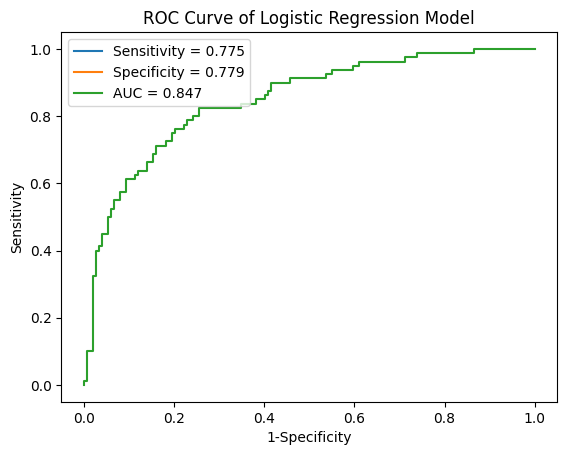

In [47]:
# Question 6 code
# Compute probabilities
y_test_prediction = logit_pipe.predict_proba(Xtest)
fpr, tpr, thresholds = roc_curve(y_true=ytest, y_score=y_test_prediction[:,1])
auc = np.round(roc_auc_score(y_true=ytest, y_score=y_test_prediction[:,1]),
               decimals = 3)
confusion_matrix_log = confusion_matrix(ytest, logit_pipe.predict(Xtest))
sensitivity = confusion_matrix_log[1,1] / (confusion_matrix_log[1,1] + confusion_matrix_log[1,0])
specificity = confusion_matrix_log[0,0] / (confusion_matrix_log[0,0] + confusion_matrix_log[0,1])


# Plot ROC curve
plt.plot(sensitivity, label=f"Sensitivity = {sensitivity:.3f}")
plt.plot(specificity, label=f"Specificity = {specificity:.3f}")
plt.plot(fpr,tpr,label=f"AUC = {auc:.3f}")
plt.legend(loc=2)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve of Logistic Regression Model')
plt.show()






**Written question: Comment on the capacity of the model to predict the outcome. Is the AUC acceptable?**

**Written answer:** The AUC is generally high, which is a good indicator that the model is adequate to predict the outcome. Additionally, our sensitivity and specificity is higher than the baseline accuracy, which shows that the model has good predictive abilities. 